# Base Modifier Deck Analysis
This is a breakdown of the damage probabilities for the base modifier deck using pands, matplotlib, and dask to simulate the deck and collect relevant statistics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
from gloomhaven.deck import GloomhavenDeck
from gloomhaven.render import render_table

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52675,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://172.20.2.148:52694,Total threads: 2
Dashboard: http://172.20.2.148:52695/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:52678,


In [3]:
deck = GloomhavenDeck()

In [4]:
@dask.delayed
def simulate(deck, n, base_attack):
    attacks = []
    deck.shuffle_deck()
    for _ in range(n):
        attacks.append(deck.get_attack(base_attack))
    return attacks

In [5]:
attack_data = {}
summary_attack_data = {}
base_attacks = [1, 2, 3, 4, 5]
samp_size = 10_000

attack_data = {}
for val in base_attacks:
    attack_data[f"base_attack_{val}"] = simulate(deck.copy(), samp_size, val)

In [6]:
attack_data = dask.compute(attack_data)
attack_data = pd.DataFrame(attack_data[0])

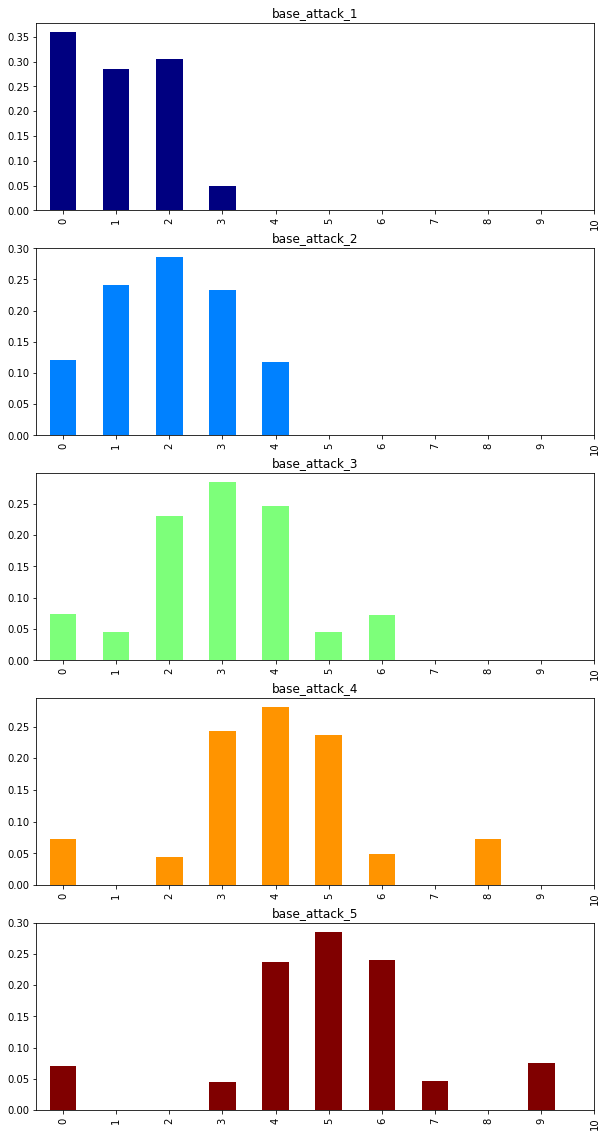

In [7]:
_ = attack_data.apply(lambda x: x.value_counts() / samp_size, axis=0) \
    .plot(
        kind="bar",
        subplots=True, 
        figsize=(10,20),
        legend=False,
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max(base_attacks)*2+1)],
    )
plt.savefig("../assets/base_deck.jpg")

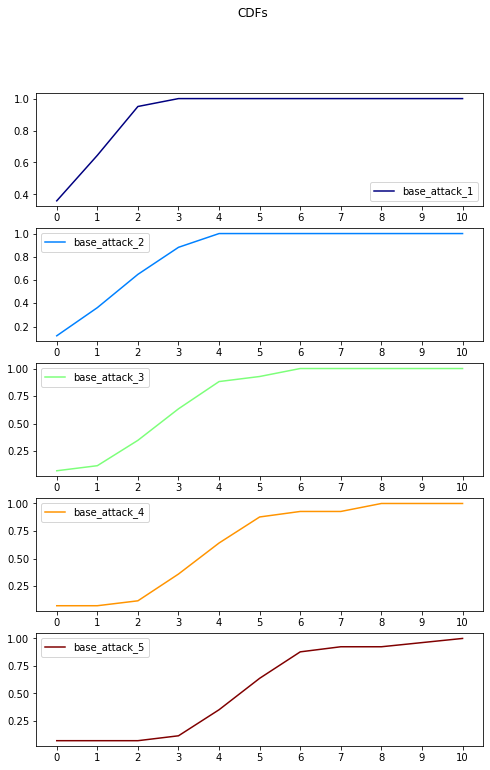

In [8]:
_ = attack_data.apply(lambda x: x.value_counts() / samp_size, axis=0) \
    .fillna(0) \
    .cumsum() \
    .plot(
        kind="line",
        subplots=True, 
        figsize=(8, 12),
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max(base_attacks)*2+1)],
        title="CDFs"
    )

tmp = attack_data.apply(lambda x: x.value_counts(normalize=True), axis=0)
missing = [i for i in range(max(tmp.index)) if i not in tmp.index]
for i in missing:
    tmp.loc[i, :] = None
tmp = tmp.fillna(0).cumsum()
tmp.sort_index(axis=0, inplace=True)
tmp_table = tmp.to_html(classes="table", border=0)

with open("../assets/base_deck_cdfs.html", "w") as f:
    f.write(render_table(tmp_table))

In [9]:
def mode(x):
    return x.value_counts().index[0]

tmp = attack_data.agg(["min", "median", "max", "mean", "std", mode])
tmp_table = tmp.to_html(classes="table", border=0)

with open("../assets/base_deck_summary_stats.html", "w") as f:
    f.write(render_table(tmp_table))

tmp

,base_attack_1,base_attack_2,base_attack_3,base_attack_4,base_attack_5
min,0.000000,0.000000,0.000000,0.000000,0.00000
median,1.000000,2.000000,3.000000,4.000000,5.00000
max,3.000000,4.000000,6.000000,8.000000,10.00000
mean,1.045000,1.984900,3.010300,3.998900,5.03430
std,0.928149,1.196585,1.471126,1.786286,2.11787
mode,0.000000,2.000000,3.000000,4.000000,5.00000
